In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric

from utils import classify, aif_dataset_loader, compute_ceop_output
from eop import EOP_Handler
from ceop import CEOP_Handler

In the following cell you can choose between the datasets, protected attributes (different depending on dataset) and which constraint to use for the calibrated equalized odds method.

The datasets are not included in the package and need to be installed manually into your local aif360 install as described here: https://github.com/Trusted-AI/AIF360/blob/main/aif360/data/README.md

In [12]:
cost_constraint = "fnr"  # "fnr", "fpr", "weighted"
dataset_used = "german"  # "adult", "german", "compas"
protected_attribute_used = 1  # 1, 2
randseed = 42

# Load datasets
dataset_train, dataset_valid, dataset_test, privileged_groups, unprivileged_groups = (
    aif_dataset_loader(dataset_used, protected_attribute_used)
)

Get a feel for the data by viewing some stats

In [13]:
print(dataset_train.features.shape)
print(dataset_train.favorable_label, dataset_train.unfavorable_label)
print(dataset_train.protected_attribute_names)
print(dataset_train.privileged_protected_attributes, dataset_train.unprivileged_protected_attributes)
print(dataset_train.feature_names)

(600, 58)
1.0 2.0
['sex', 'age']
[array([1.]), array([1.])] [array([0.]), array([0.])]
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A

In [14]:

metric_train = BinaryLabelDatasetMetric(dataset_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the training data = %f" % metric_train.mean_difference())

metric_valid = BinaryLabelDatasetMetric(dataset_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the validation data = %f" % metric_valid.mean_difference())

metric_test = BinaryLabelDatasetMetric(dataset_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups in the test data = %f" % metric_test.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups in the training data = -0.073913
Difference in mean outcomes between unprivileged and privileged groups in the validation data = -0.087674
Difference in mean outcomes between unprivileged and privileged groups in the test data = -0.064387


Next we need to get some predictions. In this notebook we used a simple logistic regression classifier, but any other model can be used in it's stead.

In [15]:
# Train a simple logistic regression classifier and get the predictions
dataset_train_pred, dataset_valid_pred, dataset_test_pred = classify(
    dataset_train, dataset_valid, dataset_test
)

Next we initialize the calibrated equalized odds model and train it on the validation data.

Next we can use some helper functions to explore the "unfairness" of our regression models predictions and compare them to the predictions transformed by our CEOP model.

In [16]:
# Initialize calibrated equalized odds handler and fit ceop model to validation data
ceop_handler = CEOP_Handler(
    dataset_valid,
    dataset_test,
    dataset_valid_pred,
    privileged_groups,
    unprivileged_groups,
    cost_constraint,
    randseed,
)

# Add datasets to the handler
ceop_handler.add_dataset("validation", dataset_valid, dataset_valid_pred)
ceop_handler.add_dataset("test", dataset_test, dataset_test_pred)

# get transformed dataset
transformed_valid_dataset = ceop_handler.get_dataset("validation")["transformed_predictions"]

# Show validation dataset metrics before and after transformation
display(Markdown("#### Original validation dataset"))
ceop_handler.print_dataset_metrics("validation", transformed=False)
print("Accuracy and equal opportunity difference:")
print((ceop_handler.get_dataset("validation")["original_performance_metrics"]))

display(Markdown("#### Transformed validation dataset"))
ceop_handler.print_dataset_metrics("validation", transformed=True)
print("Accuracy and equal opportunity difference:")
print((ceop_handler.get_dataset("validation")["transformed_performance_metrics"]))

# Show test dataset metrics before and after transformation
display(Markdown("#### Original test dataset"))
ceop_handler.print_dataset_metrics("test", transformed=False)
print("Accuracy and equal opportunity difference:")
print((ceop_handler.get_dataset("test")["original_performance_metrics"]))

display(Markdown("#### Transformed test dataset"))
ceop_handler.print_dataset_metrics("test", transformed=True)
print("Accuracy and equal opportunity difference:")
print((ceop_handler.get_dataset("test")["transformed_performance_metrics"]))

#### Original validation dataset

Difference in generalized false positive rates between groups
-0.049
Difference in generalized false negative rates between groups
-0.023
Accuracy and equal opportunity difference:
(0.72, 0.041841982234689046)


#### Transformed validation dataset

Difference in generalized false positive rates between groups
-0.022
Difference in generalized false negative rates between groups
0.011
Accuracy and equal opportunity difference:
(0.71, 0.06358111266947164)


#### Original test dataset

Difference in generalized false positive rates between groups
-0.058
Difference in generalized false negative rates between groups
0.033
Accuracy and equal opportunity difference:
(0.7, -0.0415282392026578)


#### Transformed test dataset

Difference in generalized false positive rates between groups
-0.017
Difference in generalized false negative rates between groups
0.043
Accuracy and equal opportunity difference:
(0.695, 0.004983388704318914)


We do the same for our regular equalized odds model.
We initialize the model and train it on the validation data.

Next we can use some helper functions to explore the "unfairness" of our regression models predictions and compare them to the predictions transformed by our EOP model.

In [17]:
# Initialize equalized odds handler and fit eop model to validation data
eop_handler = EOP_Handler(
    dataset_valid,
    dataset_test,
    dataset_valid_pred,
    privileged_groups,
    unprivileged_groups,
    randseed,
)

# Add datasets to the handler
eop_handler.add_dataset("validation", dataset_valid, dataset_valid_pred)
eop_handler.add_dataset("test", dataset_test, dataset_test_pred)

# get transformed dataset
transformed_valid_dataset = eop_handler.get_dataset("validation")[
    "transformed_predictions"
]

# Show validation dataset metrics before and after transformation
display(Markdown("#### Original validation dataset"))
eop_handler.print_dataset_metrics("validation", transformed=False)
print((eop_handler.get_dataset("validation")["original_performance_metrics"]))

display(Markdown("#### Transformed validation dataset"))
eop_handler.print_dataset_metrics("validation", transformed=True)
print((eop_handler.get_dataset("validation")["transformed_performance_metrics"]))

# Show test dataset metrics before and after transformation
display(Markdown("#### Original test dataset"))
eop_handler.print_dataset_metrics("test", transformed=False)
print((eop_handler.get_dataset("test")["original_performance_metrics"]))

display(Markdown("#### Transformed test dataset"))
eop_handler.print_dataset_metrics("test", transformed=True)
print((eop_handler.get_dataset("test")["transformed_performance_metrics"]))

#### Original validation dataset

Difference in false positive rates between groups
-0.186
Difference in false negative rates between groups
-0.042
(0.72, 0.041841982234689046)


#### Transformed validation dataset

Difference in false positive rates between groups
0.007
Difference in false negative rates between groups
0.002
(0.685, -0.0016362786348761427)


#### Original test dataset

Difference in false positive rates between groups
-0.104
Difference in false negative rates between groups
0.042
(0.7, -0.0415282392026578)


#### Transformed test dataset

Difference in false positive rates between groups
0.168
Difference in false negative rates between groups
0.018
(0.675, -0.01827242524916939)


Since the predictions of the CEOPs model are probabilistic, we can get a range of predictions according to a range of classification thresholds for later visualisation.

In [18]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)

(
    ceop_original_avg_odds_valid,
    ceop_original_avg_odds_test,
    ceop_post_avg_odds_valid,
    ceop_post_avg_odds_test,
    ceop_original_acc_valid,
    ceop_original_acc_test,
    ceop_post_acc_valid,
    ceop_post_acc_test,
) = compute_ceop_output(
    all_thresh=all_thresh,
    dataset_orig_valid=dataset_valid,
    dataset_orig_test=dataset_test,
    dataset_orig_valid_pred=dataset_valid_pred,
    dataset_orig_test_pred=dataset_test_pred,
    dataset_transf_valid_pred=ceop_handler.get_dataset("validation")[
        "transformed_predictions"
    ],
    dataset_transf_test_pred=ceop_handler.get_dataset("test")[
        "transformed_predictions"
    ],
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

100%|██████████| 25/25 [00:00<00:00, 156.11it/s]


Finally we visualise the performance of our models on the validation (and later test) set.

The plots shows the accuracy (higher is better) and the "fairness" (in terms of the equal opportunity difference, lower is better) of the original predictions compared to the transformed predictions of our two models.
The CEOP predictions are plotted according to the threshold range, while we only have 1 prediction for the EOP model.

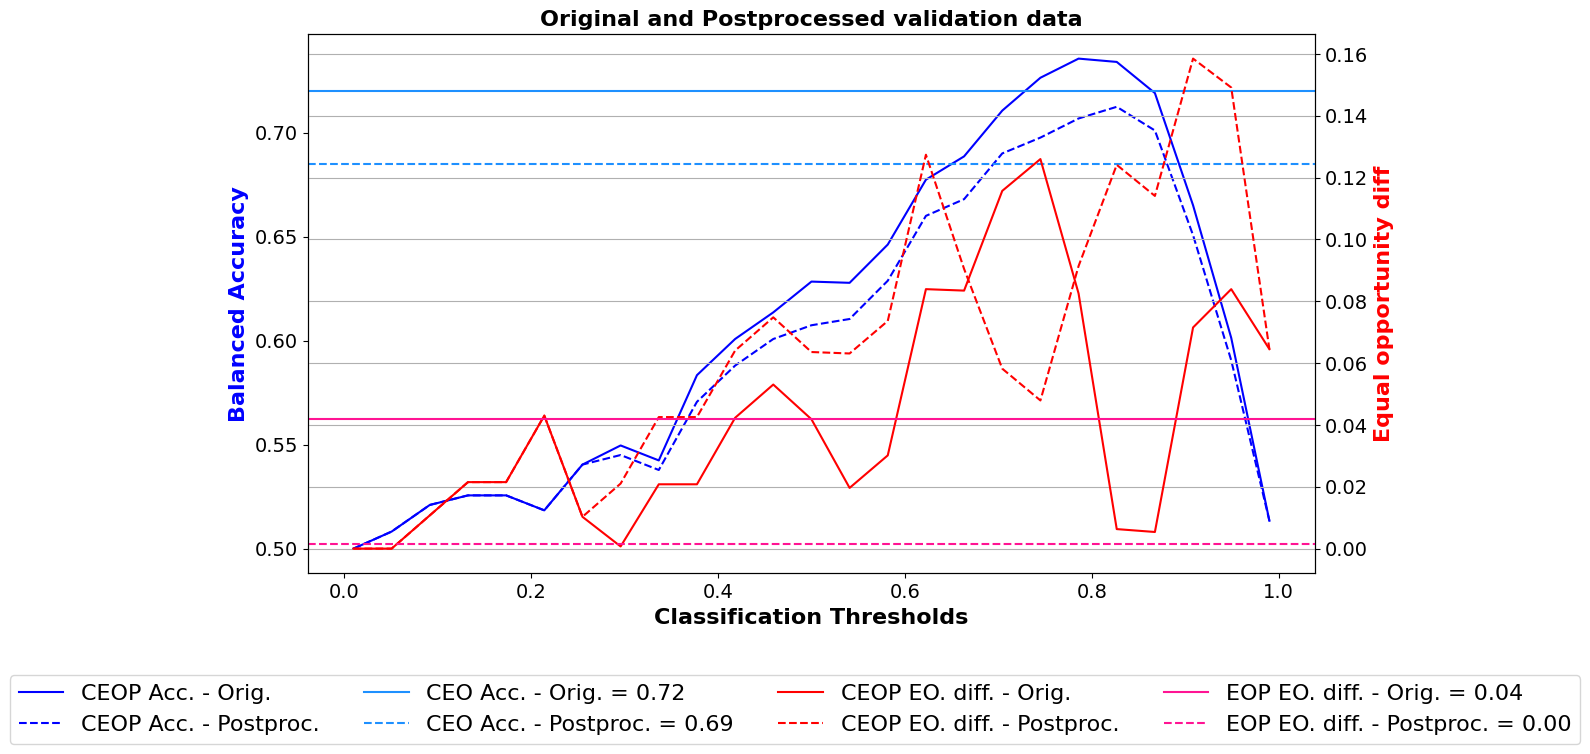

In [19]:
# Plotting the validation data results
eop_original_acc_valid, eop_original_avg_odds_valid = np.absolute(
    eop_handler.get_dataset("validation")["original_performance_metrics"]
)
eop_post_acc_valid, eop_post_avg_odds_valid = np.absolute(
    eop_handler.get_dataset("validation")["transformed_performance_metrics"]
)

ceop_original_acc_valid = np.array(ceop_original_acc_valid)
ceop_original_avg_odds_valid = np.array(ceop_original_avg_odds_valid)
ceop_post_acc_valid = np.array(ceop_post_acc_valid)
ceop_post_avg_odds_valid = np.array(ceop_post_avg_odds_valid)

fig, ax1 = plt.subplots(figsize=(13, 7))
ax1.plot(all_thresh, ceop_original_acc_valid, color="b")
ax1.plot(all_thresh, ceop_post_acc_valid, color="b", linestyle="dashed")
ax1.axhline(y=eop_original_acc_valid, color="dodgerblue", label="original accuracy")
ax1.axhline(
    y=eop_post_acc_valid,
    color="dodgerblue",
    linestyle="dashed",
    label=f"postprocessed accuracy",
)
ax1.set_title(
    "Original and Postprocessed validation data", fontsize=16, fontweight="bold"
)
ax1.set_xlabel("Classification Thresholds", fontsize=16, fontweight="bold")
ax1.set_ylabel("Balanced Accuracy", color="b", fontsize=16, fontweight="bold")
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(ceop_original_avg_odds_valid), color="r")
ax2.plot(all_thresh, np.abs(ceop_post_avg_odds_valid), color="r", linestyle="dashed")
ax2.axhline(
    y=eop_original_avg_odds_valid, color="deeppink", label="original equalized odds"
)
ax2.axhline(
    y=eop_post_avg_odds_valid,
    color="deeppink",
    linestyle="dashed",
    label="postprocessed equalized odds",
)
ax2.set_ylabel("Equal opportunity diff", color="r", fontsize=16, fontweight="bold")
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(
    [
        "CEOP Acc. - Orig.",
        "CEOP Acc. - Postproc.",
        f"CEO Acc. - Orig. = {eop_original_acc_valid:.2f}",
        f"CEO Acc. - Postproc. = {eop_post_acc_valid:.2f}",
        "CEOP EO. diff. - Orig.",
        "CEOP EO. diff. - Postproc.",
        f"EOP EO. diff. - Orig. = {eop_original_avg_odds_valid:.2f}",
        f"EOP EO. diff. - Postproc. = {eop_post_avg_odds_valid:.2f}",
    ],
    fontsize=16,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
)

plt.show()

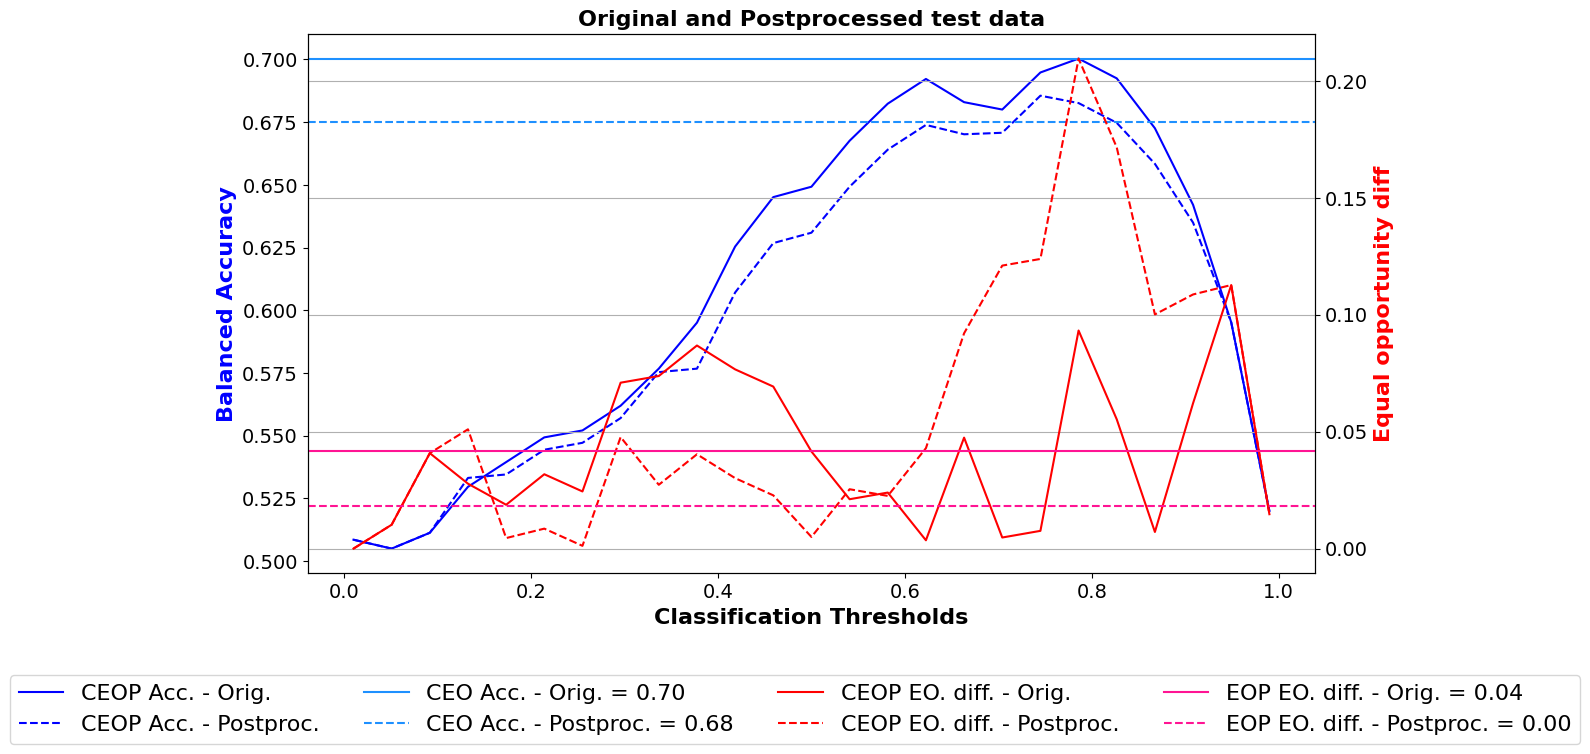

In [20]:
# Plotting the test data results
eop_original_acc_test, eop_original_avg_odds_test = np.absolute(
    eop_handler.get_dataset("test")["original_performance_metrics"]
)
eop_post_acc_test, eop_post_avg_odds_test = np.absolute(
    eop_handler.get_dataset("test")["transformed_performance_metrics"]
)

ceop_original_acc_test = np.array(ceop_original_acc_test)
ceop_original_avg_odds_test = np.array(ceop_original_avg_odds_test)
ceop_post_acc_test = np.array(ceop_post_acc_test)
ceop_post_avg_odds_test = np.array(ceop_post_avg_odds_test)

fig, ax1 = plt.subplots(figsize=(13, 7))
ax1.plot(all_thresh, ceop_original_acc_test, color="b")
ax1.plot(all_thresh, ceop_post_acc_test, color="b", linestyle="dashed")
ax1.axhline(y=eop_original_acc_test, color="dodgerblue", label="original accuracy")
ax1.axhline(
    y=eop_post_acc_test, color="dodgerblue", linestyle="dashed", label=f"postprocessed accuracy"
)
ax1.set_title(
    "Original and Postprocessed test data", fontsize=16, fontweight="bold"
)
ax1.set_xlabel("Classification Thresholds", fontsize=16, fontweight="bold")
ax1.set_ylabel("Balanced Accuracy", color="b", fontsize=16, fontweight="bold")
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(ceop_original_avg_odds_test), color="r")
ax2.plot(all_thresh, np.abs(ceop_post_avg_odds_test), color="r", linestyle="dashed")
ax2.axhline(
    y=eop_original_avg_odds_test, color="deeppink", label="original equalized odds"
)
ax2.axhline(
    y=eop_post_avg_odds_test,
    color="deeppink",
    linestyle="dashed",
    label="postprocessed equalized odds",
)
ax2.set_ylabel("Equal opportunity diff", color="r", fontsize=16, fontweight="bold")
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(
    [
        "CEOP Acc. - Orig.",
        "CEOP Acc. - Postproc.",
        f"CEO Acc. - Orig. = {eop_original_acc_test:.2f}",
        f"CEO Acc. - Postproc. = {eop_post_acc_test:.2f}",
        "CEOP EO. diff. - Orig.",
        "CEOP EO. diff. - Postproc.",
        f"EOP EO. diff. - Orig. = {eop_original_avg_odds_test:.2f}",
        f"EOP EO. diff. - Postproc. = {eop_post_avg_odds_valid:.2f}",
    ],
    fontsize=16,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
)

plt.show()